In [158]:
import numpy as np
import pandas as pd
from scipy import spatial
from random import randint
import nbconvert.filters.strings
from kneed import KneeLocator
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from matplotlib import pyplot as pyplot
pd.set_option('display.max_rows', 500)

In [26]:
# Read in processed data as dataframe
glove_vectors = pd.read_pickle('./processing/data/glove_vectors.pkl')
google_vectors = pd.read_pickle('./processing/data/google_vectors.pkl')
ft_vectors = pd.read_pickle('./processing/data/fasttext_vectors.pkl')

In [9]:
all_words = list(glove_vectors.index.get_level_values(level=0).drop_duplicates())

In [69]:
friends = ['superhero', 'cook', 'cricket', 'calf', 'apple', 'monkey']
foes = ['nut', 'mountain', 'straw', 'millionaire']
neutrals = ['mug', 'fence', 'cliff', 'brush']
assassin = ['shark']
board_words = friends + foes + neutrals + assassin

<AxesSubplot:>

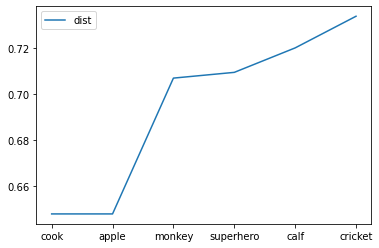

In [114]:

data = np.array([glove_vectors.loc[word].to_numpy() for word in friends])
pairwise_cos = pd.DataFrame(
    squareform(pdist(data, metric='cosine')),
    columns = friends,
    index = friends
).replace(to_replace=0, value=999)
data_dict = dict(pairwise_cos.min())
pd.DataFrame(data_dict.values(), index=data_dict.keys(), columns=['dist']).sort_values(['dist']).plot()

In [122]:
y = list(data_dict.values())
x = range(1, len(data_dict.keys())+1)

kn = KneeLocator(x, y, curve='convex', direction='decreasing')
num_friends_to_consider = kn.knee
top_friends = sorted(data_dict, key=data_dict.get, reverse=False)[:num_friends_to_consider]
low_friends = set(friends) - set(top_friends)

In [123]:
# How much more important is distance to friends, as compared to foes?
constant = 4
def distance(source, target, vectors=glove_vectors):
    return spatial.distance.cosine(vectors.loc[source].to_numpy(), vectors.loc[target].to_numpy())

def get_scores(row, vectors):
    word = row.word
    if word in board_words or any([bw in word for bw in board_words]):
        goodness = assassin_minimax = foes_minimax = neutrals_minimax = variance = -1000
    else:
        assassin_dist = [distance(word, a, vectors) for a in assassin]
        # Check if assassin distance is adequate, if not don't waste your time
        if abs(assassin_dist[0]) > 0.001:
            top_friends_dist = [distance(word, tf, vectors) for tf in top_friends]
            all_friends_dist = [distance(word, lf, vectors) for lf in low_friends]
            foes_dist = [distance(word, f, vectors) for f in foes]
            neutrals_dist = [distance(word, n, vectors) for n in neutrals]
            goodness = sum(foes_dist + assassin_dist) - constant * sum(top_friends_dist)
            min_friends_dist = min(all_friends_dist)
            max_friends_dist = max(all_friends_dist)
            assassin_minimax = min(assassin_dist) - max_friends_dist
            foes_minimax = min(foes_dist) - max_friends_dist
            neutrals_minimax = min(neutrals_dist) - max_friends_dist
            variance = max_friends_dist - min_friends_dist
    return pd.Series([goodness, assassin_minimax, foes_minimax, neutrals_minimax, variance])

In [124]:
def get_candidates_df(vectors):
    candidates = pd.DataFrame({'word': all_words, 'frequency': [i for i in range(1, len(all_words) + 1)]})
    candidates[['goodness', 'assassin_minimax', 'foes_minimax', 'neutrals_minimax', 'variance']] = candidates.apply(lambda row: get_scores(row, vectors), axis=1)
    sort_by_columns = ['goodness', 'foes_minimax', 'assassin_minimax', 'frequency', 'neutrals_minimax', 'variance']
    return candidates.sort_values(sort_by_columns, ascending=[False for i in range(len(sort_by_columns))]).reset_index(drop=True)

In [127]:
glove_candidates = get_candidates_df(glove_vectors)
google_candidates = get_candidates_df(google_vectors)
ft_candidates = get_candidates_df(ft_vectors)

In [126]:
glove_candidates.head(10)

,word,frequency,goodness,assassin_minimax,foes_minimax,neutrals_minimax,variance
0,potatoes,3794,0.489304,-0.074132,-0.264561,-0.175183,0.120026
1,bake,5357,0.435572,-0.066249,-0.275865,-0.297363,0.083878
2,baked,4638,0.360421,-0.116019,-0.354085,-0.273938,0.111226
3,baking,3111,0.306480,-0.027883,-0.289533,-0.331451,0.071054
4,onion,3965,0.291057,-0.134812,-0.304153,-0.221015,0.170277
5,oven,2679,0.265532,-0.081284,-0.253498,-0.309474,0.094439
6,casserole,10587,0.218795,-0.059612,-0.241717,-0.347470,0.088095
7,bacon,4719,0.209704,-0.180934,-0.314707,-0.288972,0.197100
8,recipe,1228,0.191947,-0.120250,-0.262955,-0.221172,0.142325
9,sauce,2156,0.167886,-0.169261,-0.315401,-0.276232,0.160288


In [128]:
google_candidates.head(20)

,word,frequency,goodness,assassin_minimax,foes_minimax,neutrals_minimax,variance
0,asparagus,10047,0.038242,-0.106608,-0.204104,-0.127454,0.177591
1,rhubarb,15116,0.010340,0.062659,-0.198247,-0.119368,0.110766
2,bake,5357,-0.031164,0.005294,-0.171971,-0.177235,0.084552
3,baking,3111,-0.083110,0.030383,-0.222491,-0.216238,0.131910
4,cauliflower,12518,-0.107344,0.016662,-0.136780,-0.021665,0.092531
5,dessert,4671,-0.119262,-0.025420,-0.175908,-0.183041,0.116600
6,pastry,7404,-0.132708,0.028600,-0.227444,-0.137355,0.021709
7,dish,2490,-0.135812,0.008008,-0.100137,-0.118803,0.030443
8,eat,746,-0.142039,-0.106756,-0.148434,-0.077177,0.151744
9,onion,3965,-0.162327,-0.084824,-0.258303,-0.135565,0.235024


In [129]:
ft_candidates.head(20)

,word,frequency,goodness,assassin_minimax,foes_minimax,neutrals_minimax,variance
0,chef,4303,-0.556660,-0.071438,-0.138529,-0.017577,0.073585
1,eat,746,-0.559276,-0.131789,-0.159909,-0.155724,0.180724
2,kitchen,968,-0.562731,0.001944,-0.077786,-0.063312,0.043206
3,orchard,11733,-0.746116,-0.035450,-0.183111,-0.168977,0.166694
4,bake,5357,-0.748544,-0.037364,-0.177547,-0.139399,0.055271
5,cider,9085,-0.755276,0.028723,-0.058438,-0.140437,0.081279
6,oven,2679,-0.769933,0.017478,-0.078304,-0.083453,0.049953
7,baker,10678,-0.773504,0.025146,-0.143901,-0.044283,0.065608
8,peel,6693,-0.798147,-0.089701,-0.165754,-0.168138,0.113583
9,pear,9364,-0.809038,-0.123308,-0.220893,-0.136809,0.149193


In [130]:
def get_final_metrics(word, candidates=[glove_candidates, google_candidates, ft_candidates]):
    total_rank = 0
    total_variance = 0
    total_goodness = 0
    for candidate_df in candidates:
        word_select = candidate_df['word'] == word
        rank = candidate_df.index[word_select].tolist()[0]
        total_rank = total_rank + rank
        variance = candidate_df[word_select].variance.tolist()[0]
        total_variance = total_variance + variance
        goodness = candidate_df[word_select].goodness.tolist()[0]
        total_goodness = total_goodness + goodness
    return pd.Series([total_rank, total_variance, total_goodness])

In [131]:
size = 25
top_candidate_words = glove_candidates.word.tolist()[:size] + google_candidates.word.tolist()[:size] + ft_candidates.word.tolist()[:size]
final_candidates = pd.DataFrame({'word': top_candidate_words})
final_candidates[['rank', 'variance', 'goodness']] = final_candidates.word.apply(lambda word: get_final_metrics(word))
final_candidates = final_candidates.drop_duplicates(subset=['word'])

In [132]:
final_candidates.sort_values(['rank', 'variance', 'goodness'], ascending=[True,True,False]).reset_index(drop=True)

,word,rank,variance,goodness
0,bake,7.0,0.223700,-0.344135
1,dish,45.0,0.210677,-1.079335
2,potatoes,58.0,0.361431,-0.887600
3,oven,59.0,0.283982,-1.052629
4,baking,64.0,0.299455,-0.886112
5,rhubarb,65.0,0.325306,-1.117230
6,dessert,65.0,0.325634,-1.225372
7,salad,72.0,0.278040,-1.347241
8,recipe,76.0,0.293170,-1.267907
9,pastry,78.0,0.172149,-1.305648


In [152]:
top_clues = ['Rab', 'Rosalia', 'Tema', 'Lilith', 'hereinafter', 'Caesarean', 'billable', 'Amara', 'Judaica', 'Estella']
top_friends = ['angel'] 
low_friends = ['match', 'poison', 'deck', 'scientist', 'dragon', 'horse', 'bow']
foes = ['horse', 'scientist', 'match', 'angel', 'deck', 'poison', 'bow', 'dragon', 'canada']
neutrals = ['china', 'hole', 'lock', 'eye', 'apple', 'knife']
assassin = ['bark']
output = pd.DataFrame(columns=['top_clues', 'top_friends', 'low_friends', 'foes', 'neutrals', 'assassin'])

In [154]:

output.loc[4] = [
    " ".join(final_candidates.word.tolist()[-10:]),
    " ".join(top_friends),
    " ".join(low_friends),
    " ".join(foes),
    " ".join(neutrals),
    " ".join(assassin)
    ]
output

,top_clues,top_friends,low_friends,foes,neutrals,assassin
2,cider baker peel browning supper maid ate dinn...,angel,match poison deck scientist dragon horse bow,horse scientist match angel deck poison bow dr...,china hole lock eye apple knife,bark
4,cider baker peel browning supper maid ate dinn...,angel,match poison deck scientist dragon horse bow,horse scientist match angel deck poison bow dr...,china hole lock eye apple knife,bark


In [155]:
from datetime import datetime
now = datetime.now()
now

datetime.datetime(2020, 7, 31, 12, 29, 1, 478521)

In [157]:
now.strftime("%m-%d-%H-%M")

'07-31-12-29'

In [159]:
candidate_df = pd.read_pickle('./output/candidate_df.pkl')
get_candidates_df

,word,frequency,goodness,assassin_dist,assassin_minimax,foes_minimax,neutrals_minimax,variance
0,crimping,130,0.462430,[0.9214597285159154],0.063558,-0.140135,-0.146321,0.042028
1,latching,80,0.380382,[0.908506190592582],0.035908,-0.111558,-0.205393,0.067160
2,crimp,51,0.321358,[0.9051461713885871],0.030612,-0.214817,-0.237900,0.085633


In [167]:
word_select = candidate_df['word'] == 'latching'
# candidate_df[word_select].frequency.iloc[0]
candidate_df[word_select].index[0]

numpy.int64

In [1]:
test = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
test[:2]

['a', 'b']